In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import os
import trackml
import time
import math
import itertools
import networkx as nx
from numba import jit
from collections import Counter
from trackml.dataset import load_event , load_dataset
from trackml.score import score_event
from scipy.spatial import distance
from IPython.display import display_html

### Importing data

In [2]:
hits_train_100, cells_train_100, particles_train_100, truth_train_100 = load_event('train_100_events/event000001000')
data_detectors = pd.read_csv(r"detectors.csv")

#print(data_detectors.iloc[:,:1])
#print(truth_train_100[0:4])

In [3]:
def func_import_100_sample():
    event_id_10 = np.linspace(0,9,10)
    event_id_100 = np.linspace(10,99,90)

    cells_all = []
    hits_all = []
    particles_all = []
    truth_all = []

    for i in range(len(event_id_10)):
        cells_all.append(pd.read_csv('train_100_events/event00000100%d-cells.csv' % event_id_10[i]))
    for i in range(len(event_id_100)):
        cells_all.append(pd.read_csv('train_100_events/event0000010%d-cells.csv' % event_id_100[i]))

    for i in range(len(event_id_10)):
        hits_all.append(pd.read_csv('train_100_events/event00000100%d-hits.csv' % event_id_10[i]))
    for i in range(len(event_id_100)):
        hits_all.append(pd.read_csv('train_100_events/event0000010%d-hits.csv' % event_id_100[i]))

    for i in range(len(event_id_10)):
        particles_all.append(pd.read_csv('train_100_events/event00000100%d-particles.csv' % event_id_10[i]))
    for i in range(len(event_id_100)):
        particles_all.append(pd.read_csv('train_100_events/event0000010%d-particles.csv' % event_id_100[i]))

    for i in range(len(event_id_10)):
        truth_all.append(pd.read_csv('train_100_events/event00000100%d-truth.csv' % event_id_10[i]))
    for i in range(len(event_id_100)):
        truth_all.append(pd.read_csv('train_100_events/event0000010%d-truth.csv' % event_id_100[i]))
    return cells_all , hits_all , particles_all , truth_all


In [4]:
# start = time.time()

# cells_all = func_import_100_sample()[0]
# hits_all = func_import_100_sample()[1]
# particles_all = func_import_100_sample()[2]
# truth_all = func_import_100_sample()[3]

# end = time.time()
# run_time = end - start
# print(run_time, "s")

### Making functions

In [14]:
def func_cleaning_data(cells , hits, particles , truth,pt_cut):
    #Finding all hit_id that is noice, to use in other files for removing nocie in them.
    def noice(truth):
        truth_hit_id_noice = [truth.hit_id[i] for i in range(len(truth)) if truth.particle_id[i] == 0]
        return truth_hit_id_noice
    truth_hit_id_noice_list = noice(truth)
    #Removing all the noice in the truth file:
    truth_zero_noice = truth.drop(truth.index[truth['particle_id'] == 0]).reset_index()
    #Removing all the data where the nhits is >=3 :
    particles_zero_noice = particles.drop(particles.index[particles['nhits'] <= 3]).reset_index()
    #Sorting the particles
    particles_zero_noice_sorted_unique = particles_zero_noice.sort_values(by = "particle_id",ascending=True)
    #Making a function that can remove all row that has a value in a list
    def FRBV(file_name, column_name, list_of_values):
        return file_name[~file_name[column_name].isin(list_of_values)]
    #Removing all the noice in the cells file:
    cells_zero_noice = FRBV(cells , "hit_id" , truth_hit_id_noice_list).reset_index()
    #Removing all the noice in the hits file:
    hits_zero_noice = FRBV(hits , "hit_id" , truth_hit_id_noice_list).reset_index()
    #Making a function that can remove all the data, that has a nhits over 7.
    def nhit_over_7(data):
        data = [data.particle_id[i] for i in range(len(data)) if data.nhits[i] > 7]
        return data
    #Removing all the data where nhits is less then 7
    particle_id_with_nhits_over_7 = nhit_over_7(particles_zero_noice_sorted_unique)
    #Removing all the data where nhits is over then 7
    particle_id_with_nhits_lees_7 = FRBV(particles_zero_noice_sorted_unique , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data where a particle_id has more then 7 nhits.
    truth_zero_noice_nhits_lees_7 = FRBV(truth_zero_noice , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Making a function that can make a list of the hit_ids that has a weight of 0.
    def weight_equle_0(data):
        data = [data.hit_id[i] for i in range(len(data)) if data.weight[i] == 0]
        return data
    #Using the weight_equle_0 function to make a list of hit_id´s that has a weight equle 0
    truth_weight_0_list = weight_equle_0(truth_zero_noice_nhits_lees_7)
    #Using the list of hit_id´s that has a weight equle 0, to remove the rows in truth that has that hit_id.
    truth_zero_noice_nhits_lees_7_weight_0 = FRBV(truth_zero_noice_nhits_lees_7,"hit_id",truth_weight_0_list).reset_index().drop("index",axis = 1)
    
    #Removing the data where the particle_id has less then 7 nhits.
    truth_zero_noice_nhits_over_7 = FRBV(truth_zero_noice , "particle_id" ,truth_zero_noice_nhits_lees_7.particle_id).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing the data where the hit_id has less the 7 nhits.
    hits_zero_noice_nhits_lees_7 = FRBV(hits_zero_noice, "hit_id",truth_zero_noice_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Making a list of all the particle_ids that has over 3 nhits
    particles_id_over_3 = [particles.particle_id[i] for i in range(len(particles)) if particles.nhits[i] > 3]
    #Removing all the data in truth that has less the 3 nhits. Used for later in cells and hits.  
    truth_zero_noice_over_3 = FRBV(truth_zero_noice,"particle_id",particles_id_over_3).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data in hits that has over the 3 nhits.
    hits_zero_noice_nhits_lees_7_over_3_with_weight_0 = FRBV(hits_zero_noice_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1)
    #Making a list of hit_id that is not in truth but is in hits
    hit_id_in_hits_but_not_in_truth = FRBV(hits_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)
    #Using that hits not in truth, and then removing them from hits. 
    hits_zero_noice_nhits_lees_7_over_3_without_weight_0 = FRBV(hits_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_hits_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1)

    #Removing the data where the hit_id has less the 7 nhits.
    cells_zero_noice_nhits_lees_7 = FRBV(cells_zero_noice, "hit_id",truth_zero_noice_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    #Removing all the data in cells that has over the 3 nhits.
    cells_zero_noice_nhits_lees_7_over_3_with_weight_0 = FRBV(cells_zero_noice_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1)
    #Making a list of hit_id that is not in truth but is in cells
    hit_id_in_cells_but_not_in_truth = FRBV(cells_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)
    #Using that cells hit_id not in truth, and then removing them from cells.
    cells_zero_noice_nhits_lees_7_over_3_without_weight_0 = FRBV(cells_zero_noice_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_cells_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1)
    
    #Putting all the data from truth into hits:
    hits_merge = hits_zero_noice_nhits_lees_7_over_3_without_weight_0.merge(truth_zero_noice_nhits_lees_7_weight_0, how='left', on='hit_id')
    #Making a same layer filter 
    def same_layer_filter(hits_new):
        hits_long_layer_filtert = hits_new.drop_duplicates(subset = ["particle_id","volume_id", "layer_id"])
        return hits_long_layer_filtert
    hits_long_layer_filtert = same_layer_filter(hits_merge)
    #Making a function that can show the removed particles from same layer filter.
    def Remove_Elements(data, thrsshold):
        counted = Counter(data)
        temp_lst = []
        for i in counted:
            if counted[i] < thrsshold:
                temp_lst.append(i)
        res_lst = []
        for i in data:
            if i not in temp_lst:
                res_lst.append(i)
        data = [i for i in data if counted[i] >= thrsshold]
        return data , temp_lst , res_lst
    thrsshold = 4
    hits_filtert , particles_nhits_less_4 , particles_nhits_over_4 = Remove_Elements(hits_long_layer_filtert["particle_id"],thrsshold)
    #Removing the particles from the same layer filter in hits_merge and particle file
    hits_merge_filtered = FRBV(hits_long_layer_filtert ,"particle_id", particles_nhits_less_4).reset_index().drop("index",axis = 1)
    particles_merge_filtered = FRBV(particle_id_with_nhits_lees_7 ,"particle_id", particles_nhits_less_4).reset_index().drop("index",axis = 1)

    #Calculating the pt of a particle:
    Pt = []
    for i in (range(len(particles_merge_filtered))):
        func = (particles_merge_filtered.px[i]**2+particles_merge_filtered.py[i]**2)**(1/2)
        Pt.append([particles_merge_filtered.particle_id[i],func])
    #Making the pt filter loop
    Pt_1GeV = []
    for i in range(len(Pt)):
        if Pt[i][1] >= pt_cut:  # and Pt[i][1] <= 2
            Pt_1GeV.append(Pt[i])
    #Finding the particles from the pt filter 
    particles_over_Pt_1GeV = []
    for i in range(len(Pt_1GeV)):
        particles_over_Pt_1GeV.append(Pt_1GeV[i][0])
    # Making a function that keeps values that is in list, and removes the ones that is not. 
    def FCBV(file_name, column_name, list_of_values):
        return file_name[file_name[column_name].isin(list_of_values)]
    #Removing the rows from the pt filter.  
    particles_over_Pt_1GeV_filtered = FCBV(particles_merge_filtered ,"particle_id", particles_over_Pt_1GeV).reset_index().drop("index",axis = 1)
    hits_merge_over_Pt_1GeV_filtered = FCBV(hits_merge_filtered ,"particle_id", particles_over_Pt_1GeV).reset_index().drop("index",axis = 1)
    return  hits_merge_over_Pt_1GeV_filtered , particles_over_Pt_1GeV_filtered

In [19]:
%%time
hits_merge, particles_1GeV = func_cleaning_data(cells_train_100,hits_train_100,particles_train_100,truth_train_100,1)

print( len(hits_merge),len(particles_1GeV))


465 94
Wall time: 1.39 s


### Calling data cleaning data

In [7]:
# Start = time.time()

# for i in range(100):
#     cells_all_clean , hits_all_clean , particles_all_clean, truth_all_clean  = func_cleaning_data(cells_all[i],hits_all[i],particles_all[i],truth_all[i])

# end = time.time()
# run_time = end - Start
# print(round(run_time,4), "s")

### Making a same layer filter and after nhits filter again:

In [8]:
%%time

def car_to_cyl_cood(x,y,z):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    z = z
    return r , phi , z 

r_hits , phi_hits , z_hits = car_to_cyl_cood(hits_merge.x,hits_merge.y,hits_merge.z)

hits_merge["phi"] = phi_hits
hits_merge["r"] = r_hits

def car_to_sphe_cood(r,z):
    theta = np.arctan2(r,z)
    return theta

theta = car_to_sphe_cood(r_hits,z_hits)

print(min(theta),max(theta))

#plt.plot(theta)

0.09668378531932831 3.0623741149902344
Wall time: 1.99 ms


In [9]:
%%time

def edge_feat(r,phi,z, theta):
    r = list(r)
    phi = list(phi)
    z = list(z)
    dphi = []
    z_0 = []
    eta = -np.log(np.tan(theta/2))  # the pseudoangular
    delta_phi = []
    delta_eta = []
    delta_z = []
    delta_r = []
    for i in range(0,len(r)-1): #i=1  , i=2
        for k in range(1,len(r)): #k=1-len(r) ,k=1-len(r)
            dp = phi[k] - phi[i]
            delta_phi.append(dp)
            delta_eta_values = eta[k] - eta[i]
            delta_eta.append(delta_eta_values)
            delta_z_values = z[k] - z[i]
            delta_z.append(delta_z_values)
            delta_r_values = r[k] - r[i]
            delta_r.append(delta_r_values)
            dr = r[k] - r[i]
            dpi = dp/dr
            z0 = z[i] - r[i]*((z[k] - z[i])/(r[k]-r[i]))
            if abs(dpi) < 0.0006 and abs(z0) < 200:
                dphi.append(dpi)
                z_0.append(z0)
        return dphi, z_0 , eta , delta_phi , delta_eta, delta_z , delta_r

dphi, z_0 , eta , delta_phi , delta_eta, delta_z ,delta_r = edge_feat(r_hits,phi_hits,z_hits,theta)

def delta_R(delta_eta,delta_phi):
    delta_R = []
    for i in range(len(delta_eta)):
        delta_R.append((delta_eta[i]**2 + delta_phi[i]**2)**(1/2))
    return delta_R

delta_R = delta_R(delta_eta,delta_phi)


Wall time: 3.99 ms


In [10]:
#Making the datafram that contains the nodes ids and the nodes features. 
nodes_id_plus_features = hits_merge[["hit_id","z","r","phi"]].copy()
#Making the datafram that contains the edges features. 
edges_features= {'delta_r': delta_r , 'delta_phi': delta_phi , "delta_z": delta_z , "delta_R": delta_R} 
edges_features = pd.DataFrame(data = edges_features)

display(nodes_id_plus_features)
display(edges_features)

,hit_id,z,r,phi
0,2274,-1298.0,163.245209,-0.244324
1,3504,-1098.0,87.265312,-2.251008
2,3588,-1098.0,152.552094,-2.093910
3,4206,-1098.0,137.925751,-0.238793
4,4941,-1098.0,118.572090,1.778811
...,...,...,...,...
460,119069,1502.5,912.669495,2.388788
461,119314,1797.5,807.205994,-0.192559
462,119561,2147.5,808.090149,-2.861287
463,119728,2152.5,973.528870,-0.162484


,delta_r,delta_phi,delta_z,delta_R
0,-75.979897,-2.006684,200.0,2.057978
1,-10.693115,-1.849586,200.0,1.852219
2,-25.319458,0.005531,200.0,0.005659
3,-44.673119,2.023136,200.0,2.028790
4,-87.123985,-2.008039,340.0,2.059350
...,...,...,...,...
459,749.424286,2.633113,2800.5,4.825397
460,643.960785,0.051765,3095.5,4.311417
461,644.844940,-2.616963,3445.5,5.183674
462,810.283661,0.081840,3450.5,4.305398


### Kigger på data

### Ploting data pre GNN

In [11]:
def plotting_data(data_rough,data_clean):
    XYZ_rough = [[],[],[]]
    XYZ_clean = [[],[],[]]
    for i, idx in enumerate(range(len(data_rough.x))):
        if abs(data_rough.z[i]) < 2000:
            XYZ_rough[0].append((data_rough.x[idx]))
            XYZ_rough[1].append((data_rough.y[idx]))
            XYZ_rough[2].append((data_rough.z[idx]))
    print(len(XYZ_rough[0]), len(XYZ_rough[1]), len(XYZ_rough[2]))

    for i, idx in enumerate(range(len(data_clean.x))):
        if abs(data_clean.z[i]) < 2000:
            XYZ_clean[0].append((data_clean.x[idx]))
            XYZ_clean[1].append((data_clean.y[idx]))
            XYZ_clean[2].append((data_clean.z[idx]))
    print(len(XYZ_clean[0]), len(XYZ_clean[1]), len(XYZ_clean[2]))
    return XYZ_rough , XYZ_clean

XYZ_rough , XYZ_clean = plotting_data(hits_train_100,hits_merge)

110919 110919 110919
450 450 450


(-2000.0, 2000.0)

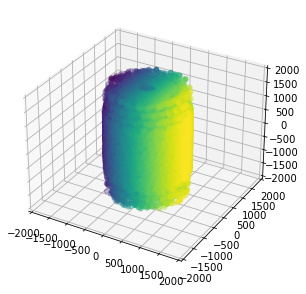

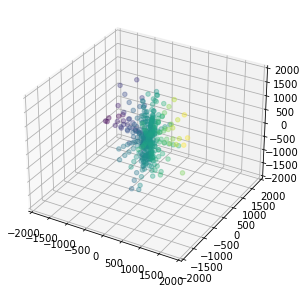

In [12]:
zoom = 2000
figsize = 5
alpha = 0.35

fig = plt.figure(1, figsize = (figsize,figsize))
ax = plt.axes(projection='3d')
ax.scatter3D(XYZ_rough[0],XYZ_rough[1],XYZ_rough[2], c = XYZ_rough[0], alpha = alpha)
plt.xlim(-zoom,zoom)
plt.ylim(-zoom,zoom)
ax.set_zlim(-zoom,zoom)


fig = plt.figure(2, figsize = (figsize,figsize))
ax = plt.axes(projection='3d')
ax.scatter3D(XYZ_clean[0],XYZ_clean[1],XYZ_clean[2], c = XYZ_clean[0] , alpha = alpha)
plt.xlim(-zoom,zoom)
plt.ylim(-zoom,zoom)
ax.set_zlim(-zoom,zoom)

In [13]:
plt.figure(1)
plt.pie(particles.groupby('q')['vx'].count(), labels=['negative', 'positive'],autopct='%.0f%%',shadow=True, radius=1,textprops=dict(color="w"))
plt.title('Distribution of particle charges:',color = "white")
plt.show()

NameError: name 'particles' is not defined

<Figure size 432x288 with 0 Axes>

### Looking at the detector

In [ ]:
x = data_detectors.cx
y = data_detectors.cy
z = data_detectors.cz
fig = plt.figure(5, figsize = (10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(z , y ,x, c = y, alpha = 0.5)